# What's driving logerror?

## Project Goals
* Identify key features that can be used to create an effective predictive model.
* Use regression models to make logerror predictions.
* Use findings to make recommendations and establish a foundation for future work to improve model's performance.

## Imports

In [1]:
#list all of the imports I used in this notebook or in a module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")
from importlib import reload


#import my personal modules created for this report
import wrangle as w
#import explore as e
#import model as m

## Acquire

* Data acquired from the Codeup mySQL server on November 30, 2022.
* It contained 52205 rows and 15 columns
* Each observation represents a single-family home where ```latitude```, ```longitude```, and ```yearbuilt``` are NOT NULL
* Each column represents a feature of those homes

In [2]:
#import unclean data from Codeup mySQL server
zillow_unclean = w.acquire_zillow_data()

In [3]:
zillow_unclean.shape

(52205, 15)

## Prepare

#### NULLs to 0
* For ```fireplace```, ```deck```, ```pool```, ```garage```, and ```hottub``` it was assumed NULL values indicated it did not exist on property so NULLs were converted to "0".

#### Created features
* ```county``` (names based on the fips code):  
    - 6037: LA
    - 6059: Orange 
    - 6111: Ventura 
* ```2017_age```
    - Column diplaying age of house in 2017 (2017-year_built)
    
#### Dropped rows:
* Rows containing null values in any column (< 1% dropped)

#### Other prep
* Split data into train, validate, and test (65/20/15)


***51843 rows before splitting*** 

In [4]:
#clean data
zillow = w.clean_zillow(zillow_unclean)

(51843, 15)

In [6]:
#split data
train, validate, test = w.split_data(zillow)

### Data dictionary
| Feature | Definition | Type |
|:--------|:-----------|:-------
|**parcelid**| Definition| *int*|
| **bathroooms** | The number of bathrooms in the home. |*float*|
| **bedrooms** | The number of bedrooms in the home.|*int*|
|**sqft**| Square footage of the house| *int*|
|**year_built**| Year the house was built| *int*|
|**latitude**| | *float*|
|**longitude**| | *float*|
|**lotsizesquarefeet**| Square footage of the land where the property is located | *float*|
|**fireplace**| | *float*|
|**deck**| | *float*|
|**pool**| | *float*|
|**garage**| | *float*|
|**hottub**| | *float*|
|**county**| Name of the county where the house is located| *string*|
|**2017_age**| Age of the house in 2017 (when the data was collected| *int*|
|**Target variable**
|**logerror**| 𝑙𝑜𝑔𝑒𝑟𝑟𝑜𝑟=𝑙𝑜𝑔(𝑍𝑒𝑠𝑡𝑖𝑚𝑎𝑡𝑒)−𝑙𝑜𝑔(𝑆𝑎𝑙𝑒𝑃𝑟𝑖𝑐𝑒) | *float* |

### A look at the data

In [9]:
#show the first few rows of the train data
train.head()

,parcelid,logerror,bathrooms,bedrooms,sqft,latitude,longitude,lotsizesquarefeet,fireplace,deck,pool,garage,hottub,county,2017_age
46729,11669351,0.037,4.000,4,3470,"34,045,821.000","-118,517,058.000",7148,0,0,0,0,0,LA,12
47582,13844703,-0.104,1.000,3,999,"33,728,543.000","-117,879,618.000",6716,0,0,1,1,1,Orange,67
32610,14110023,0.043,3.000,5,1803,"33,825,991.000","-118,045,155.000",6203,0,0,0,1,1,Orange,53
22180,11703748,-0.003,1.000,2,1586,"34,001,625.000","-118,304,436.000",5867,0,0,0,0,0,LA,105
28282,13899266,0.166,1.000,2,902,"33,427,590.000","-117,617,406.000",4600,0,0,0,1,1,Orange,57


## Explore

### 1. What is the distribution of logerror based on county?

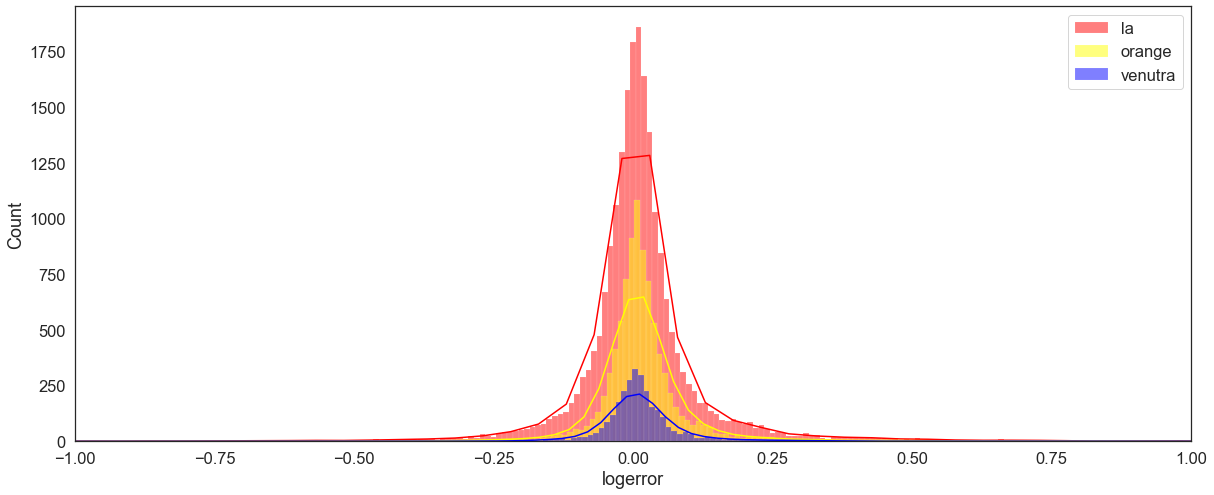

In [16]:
#set font size
sns.set(font_scale=1.5)
#set plot style
sns.set_style('white')
fig, ax = plt.subplots(1,1, figsize=(20,8))

sns.histplot(train[train.county=='LA'].logerror, kde=True, ax=ax, binwidth=.01, color='red', label='la')
sns.histplot(train[train.county=='Orange'].logerror, kde=True, ax=ax, binwidth=.01,color ='yellow', label='orange')
sns.histplot(train[train.county=='Ventura'].logerror, kde=True, ax=ax, binwidth=.01, color='blue', label='venutra')
ax.set_xlim(-1,1)
ax.legend()
plt.show()

**Looks as if logerror is normally distributed AND there is not much difference between the counties.** 

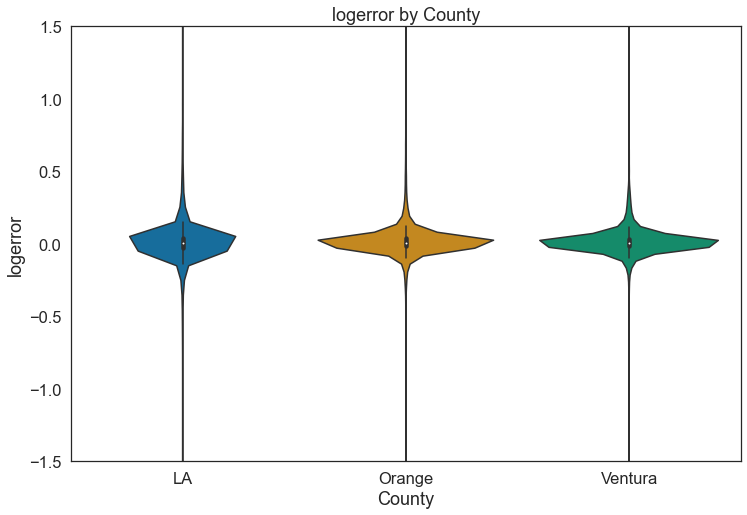

In [23]:
#make plot
fig, ax = plt.subplots(1,1, figsize=(12,8))
sns.violinplot(data = train, x = 'county', y = 'logerror', palette='colorblind', ax=ax)
ax.set_title('logerror by County')
ax.set_xlabel('County')
ax.set_ylim(-1.5,1.5)
plt.show()

**It looks like there is a difference in home values in each county.**

$H_0$ = Average logerror of those in LA county, Orange county and Ventura county are the same.

$H_a$ = Average logerror of those in LA county, Orange county and Ventura county are not the same.

In [12]:
#splitting data into a df per county:
la = train[train.county == 'LA'].logerror
orange = train[train.county == 'Orange'].logerror
ventura = train[train.county == 'Ventura'].logerror

#Running a one-way ANOVA (there is a single independent variable - 'county'):
f, p = stats.kruskal(la, orange, ventura)

#print results
print(f"F-score: {f:.8}\np-value: {p:.4}")

F-score: 40.504427
p-value: 1.602e-09


**Since p < alpha we can reject the null hypothesis and say Average logerror of those in LA county, Orange county and Ventura county are not the same.**

### 2. What is the relationship between sqft and logerror? 

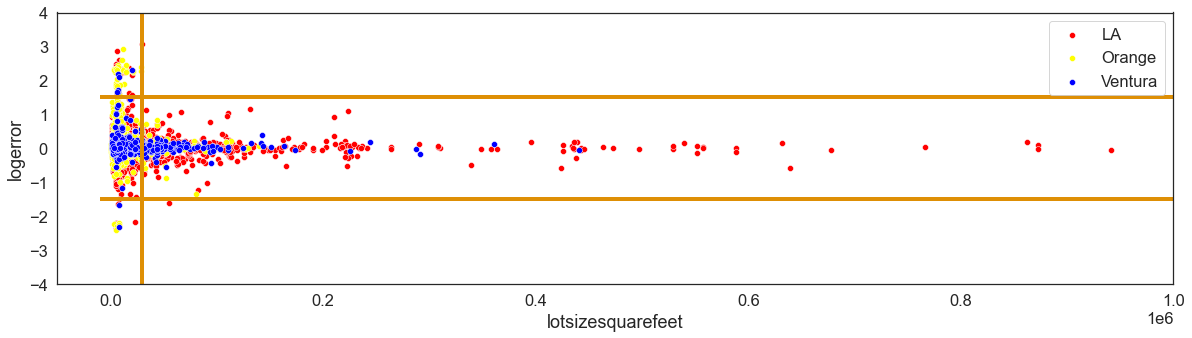

In [15]:
#set font size
sns.set(font_scale=1.5)
#set plot style
sns.set_style('white')

#make plot
fig, ax = plt.subplots(1,1, figsize=(20,5))
sns.scatterplot('lotsizesquarefeet', 'logerror', label='LA', data=train[train.county=='LA'], color = "red")
sns.scatterplot('lotsizesquarefeet', 'logerror', label='Orange', data=train[train.county=='Orange'], color="yellow")
sns.scatterplot('lotsizesquarefeet', 'logerror', label='Ventura', data=train[train.county=='Ventura'], color="blue")
ax.vlines(30000, -4, 4, color="#de8f05", linewidth=4)
ax.set_ylim(-4,4)
ax.hlines(1.5, -10000, 1000000, color="#de8f05", linewidth=4)
ax.hlines(-1.5, -10000, 1000000, color="#de8f05", linewidth=4)
ax.set_xlim(-50000,1000000)
ax.set_ylabel("logerror")
ax.legend()
plt.show()

**It looks like there is a linear correlation between square feet and logerror.** 

***Also looks like the original model did a good job at predicting larger homes.***

**Set Hypothesis**

$H_0$ = There is no linear correlation between sqft and logerror 

$H_a$ = There is a linear correlation between sqft and logerror 

In [10]:
 #run spearman test to see if there is any linear correlation
corr, p = stats.spearmanr(train.sqft, train.logerror)

#print results
print(f"Correlation Coefficient: {corr:.2}\np-value: {p:.4}")

Correlation Coefficient: 0.079
p-value: 9.264e-48


**p < alpha, so we can reject the null hypothesis and say there is probably a a linear correlation between square footage and logerror.** 

In [7]:
train_scale, validate_scale, test_scale =w.scale_zillow(train, validate, test, 'logerror')

## 3. ??????

## 4. ???????

**It looks like there is a linear correlation between ?????? and logerror**

**Set Hypothesis**

$H_0$ = There is no linear correlation between ?????? and logerror 

$H_a$ = There is a linear correlation between ?????? and logerror

In [13]:
#run spearmanr test and show results
#e.age_spearmanr(train)

**p < alpha, so we can reject the null hypothesis and say there is probably a a linear correlation between 2017_age and home value.** 

### Exploration Summary
* ```square_feet``` has the highest correlation coefficient so I will use it in my model.
* ```bed_bath_ratio```, ```2017_age```, and ```county``` all show a relationship with home value so I will also take them to my model.

### Features I'm moving on with
| Feature | Reason | 
|:--------|:-----------|
|**square_feet**| From our Spearman's test we saw that the correlation coefficient is 0.48 between ```square_feet``` and ```home_value```|
|**bath_bed_ratio**| From our Spearman's test we saw that the correlation coefficient is 0.32 between ```bath_bed_ratio``` and ```home_value```|
|**2017_age**| From our Spearman's test we saw that the correlation coefficient is 0.27 between ```2017_age``` and ```home_value```|
|**county**| From our ANOVA test we see that there is a difference between the home values in each county|

### Features I'm not moving on with

| Feature | Reason 
|:--------|:-----------
|**parcelid**| id number that is not needed in the model
| **bathroooms** | Represented in the ```bath_bed_ratio``` so it would be redundant.
| **bedrooms** | Represented in the ```bath_bed_ratio``` so it would be redundant.
|**year_built**| Represented in the ```2017_age``` so it would be redundant.

In [30]:
sqft_lotsize_cluster = train_scale[['sqft', 'lotsizesquarefeet']]

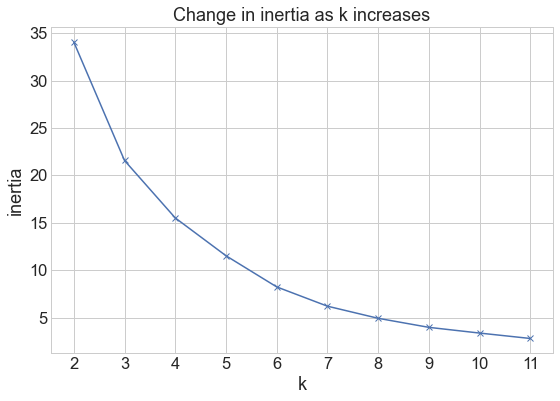

In [31]:
from sklearn.cluster import KMeans
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(sqft_lotsize_cluster).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [32]:
#Fit a new model to my scaled data
kmeans_scale = KMeans(n_clusters=5)

kmeans_scale.fit(sqft_lotsize_cluster)

train_scale['sqft_lotsize_cluster'] = kmeans_scale.predict(sqft_lotsize_feature)

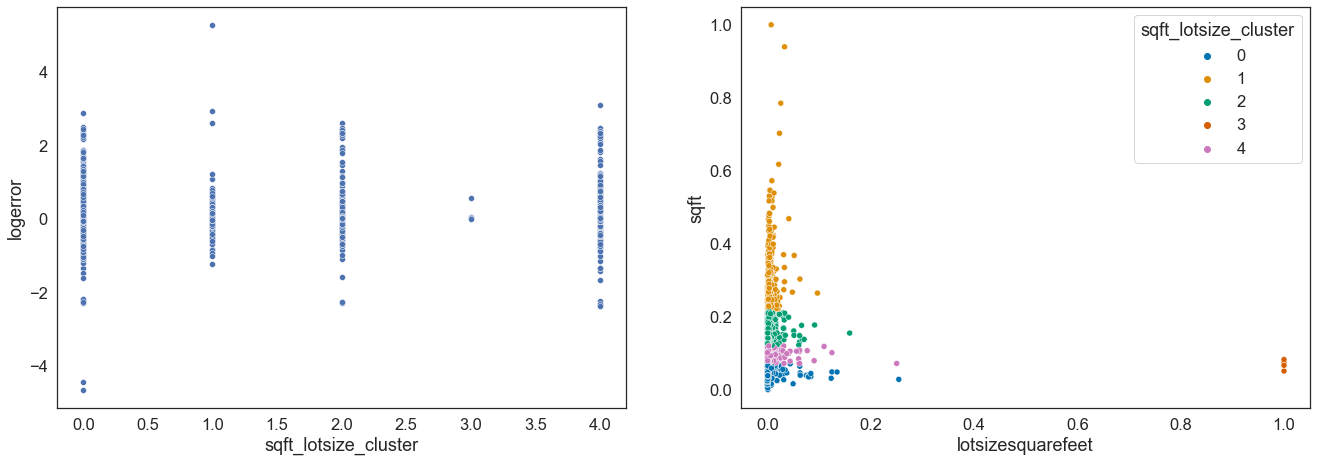

In [33]:
sns.set(font_scale=1.5)
sns.set_style('white')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
fig.tight_layout(pad=4.0)

sns.scatterplot(ax=ax1, y='logerror', x='sqft_lotsize_cluster',
                palette='colorblind', data=train_scale)
sns.scatterplot(ax=ax2, y='sqft', x='lotsizesquarefeet', hue='sqft_lotsize_cluster',
                palette='colorblind', data=train_scale)

plt.show()

# Modeling

### Prep for modeling
* I scaled the drivers using the minmax scaler
* Split the data into where ```home_value``` is the target variable

In [15]:
#prepare data for modeling
X_train, y_train, X_validate, y_validate, X_test, y_test = w.prep_for_model(train, validate, test, 'logerror', drivers)

### Baseline models
* Looked at both using mean and median as a baseline model.
* Mean baseline performed better on the in-sample and out-of sample data SO I went with mean.

In [18]:
import sklearn.metrics as metric

def baseline_models(y_train, y_validate):
    '''
    Takes in y_train and y_validate and returns a df of 
    baseline_mean and baseline_median and how they perform
    '''
    train_predictions = pd.DataFrame(y_train)
    validate_predictions = pd.DataFrame(y_validate)
    
    y_pred_mean = y_train.mean()
    train_predictions['y_pred_mean'] = y_pred_mean
    validate_predictions['y_pred_mean'] = y_pred_mean
    
    y_pred_median = y_train.median()
    train_predictions['y_pred_median'] = y_pred_median
    validate_predictions['y_pred_median'] = y_pred_median

    # create the metric_df as a blank dataframe
    metric_df = pd.DataFrame(data=[
    {
        'model': 'mean_baseline', 
        'RMSE_train': metric.mean_squared_error(
            y_train,
            train_predictions['y_pred_mean']) ** .5,
        'RMSE_validate': metric.mean_squared_error(
            y_validate,
            validate_predictions['y_pred_mean']) ** .5,
        'Difference': (( metric.mean_squared_error(
            y_train,
            train_predictions['y_pred_mean']) ** .5)-(metric.mean_squared_error(
            y_validate,
            validate_predictions['y_pred_mean']) ** .5))
    }])

    return metric_df.append(
            {
                'model': 'median_baseline', 
                'RMSE_train': metric.mean_squared_error(
                    y_train,
                    train_predictions['y_pred_median']) ** .5,
                'RMSE_validate': metric.mean_squared_error(
                    y_validate,
                    validate_predictions['y_pred_median']) ** .5,
                'Difference': (( metric.mean_squared_error(
                    y_train,
                    train_predictions['y_pred_median']) ** .5)-(metric.mean_squared_error(
                    y_validate,
                    validate_predictions['y_pred_median']) ** .5))
            }, ignore_index=True)

In [19]:
baseline_models(y_train, y_validate)

,model,RMSE_train,RMSE_validate,Difference
0,mean_baseline,0.174556,0.18238,-0.007824
1,median_baseline,0.174886,0.18275,-0.007864


### Model Comparison

In [ ]:
#run and compare models
#m.regression_models(X_train, y_train, X_validate, y_validate)

### Comparing Models
* All models perfomed better than baseline for both train and validate data.
* It was interesting that OLS Regressor and Lasso Lars both performed better on the out-of-sample data.

### Best model: Random Forest Model 
* I chose the XXX (XXXXXXXXXX) because the difference in $RMSE$ between the train and validate was around  and they were both higher than the other models
* I will now run the that model on test data to gauge how it will perform on future data

In [ ]:
#m.best_model(X_train, y_train, X_validate, y_validate, X_test, y_test)

**This model performs better than baseline and with very similar accuracy across all three data sets (train, validate and test).**

## Conclusion

### Summary
*


### Recommendations
* We should do more research .
* .

### Next Steps
* In the next iteration:
    * 